# GeneRec 稳定版：Sigmoid 激活 + Feedback 衰减 + 状态变化监控

In [1]:

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml


In [2]:

mnist = fetch_openml('mnist_784', version=1)
X = torch.tensor(mnist.data.values, dtype=torch.float32) / 255.0
y = torch.tensor(mnist.target.astype(int).values)

mask = (y == 0) | (y == 1)
X = X[mask]
y = y[mask]

def one_hot(y, num_classes=2):
    return torch.eye(num_classes)[y]

y_onehot = one_hot(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)


In [3]:

class GeneRecNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, alpha=0.3):
        super(GeneRecNet, self).__init__()
        self.W1 = nn.Parameter(torch.randn(hidden_dim, input_dim) * 0.1)
        self.W2 = nn.Parameter(torch.randn(output_dim, hidden_dim) * 0.1)
        self.alpha = alpha  # feedback 衰减系数

    def sigmoid(self, x):
        return 1 / (1 + torch.exp(-x))

    def dsigmoid(self, x):
        s = self.sigmoid(x)
        return s * (1 - s)

    def forward_positive(self, x, target):
        raw_h = self.W1 @ x.T
        feedback = self.alpha * (self.W2.T @ target.T)
        h = self.sigmoid(raw_h + feedback)
        return x, h, target.T

    def forward_negative(self, x):
        h_raw = self.sigmoid(self.W1 @ x.T)
        y_hat = self.sigmoid(self.W2 @ h_raw)
        return x, h_raw, y_hat


In [4]:

def update_weights(model, pos_h, pos_y, neg_h, neg_y, x, lr=0.01):
    delta_W2 = ((pos_y - neg_y) @ pos_h.T) / x.shape[0]
    model.W2.data += lr * delta_W2

    grad_h = pos_h * (1 - pos_h)
    delta_W1 = (((pos_h - neg_h) * grad_h) @ x) / x.shape[0]
    model.W1.data += lr * delta_W1


In [5]:

def visualize_hidden(pos_h, neg_h, title='Hidden Activations: Positive vs Negative'):
    pos = pos_h.T.detach().numpy()
    neg = neg_h.T.detach().numpy()
    pca = PCA(n_components=2)
    all_points = pca.fit_transform(np.vstack([pos, neg]))
    pos_points = all_points[:len(pos)]
    neg_points = all_points[len(pos):]
    plt.figure(figsize=(6, 5))
    plt.scatter(pos_points[:, 0], pos_points[:, 1], alpha=0.5, label='Positive Phase')
    plt.scatter(neg_points[:, 0], neg_points[:, 1], alpha=0.5, label='Negative Phase')
    plt.title(title)
    plt.legend()
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.grid(True)
    plt.show()


Epoch 0 | Hidden Phase Δ: 0.0360


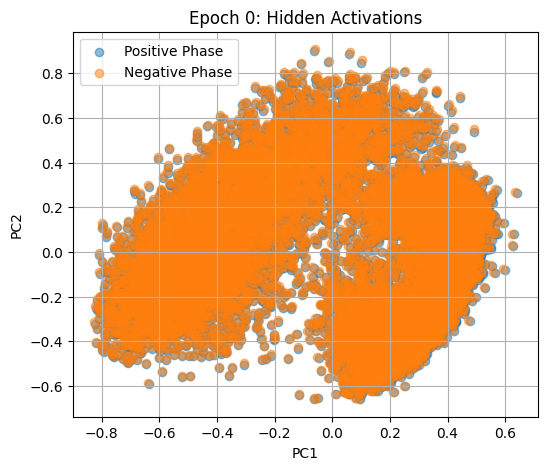

Test Accuracy: 0.4878
Epoch 10 | Hidden Phase Δ: 0.0367


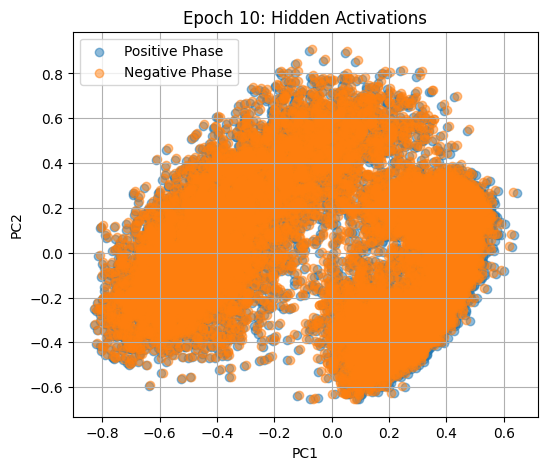

Test Accuracy: 0.6806
Epoch 20 | Hidden Phase Δ: 0.0383


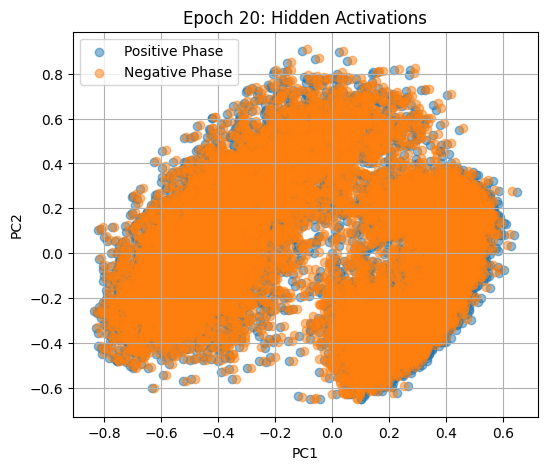

Test Accuracy: 0.6380
Epoch 30 | Hidden Phase Δ: 0.0406


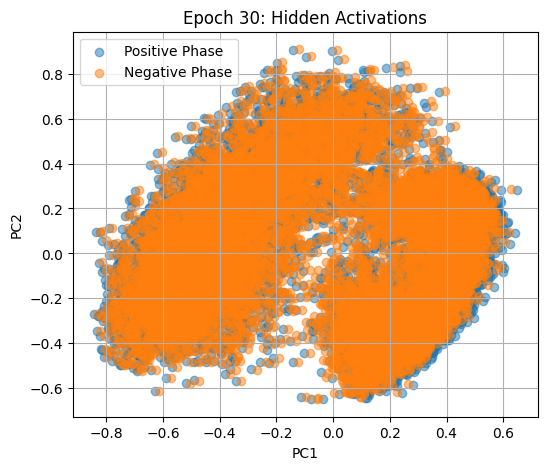

Test Accuracy: 0.6850
Epoch 40 | Hidden Phase Δ: 0.0434


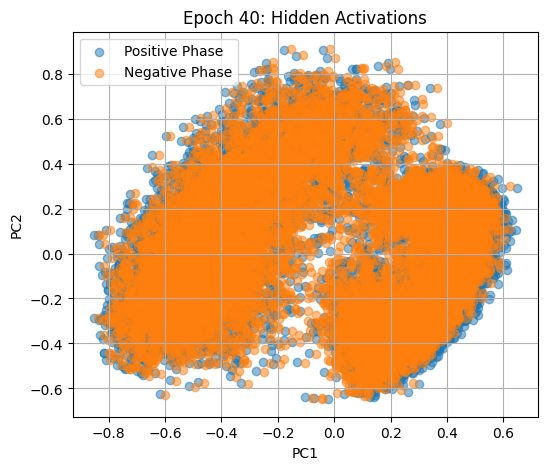

Test Accuracy: 0.7554
Epoch 50 | Hidden Phase Δ: 0.0467


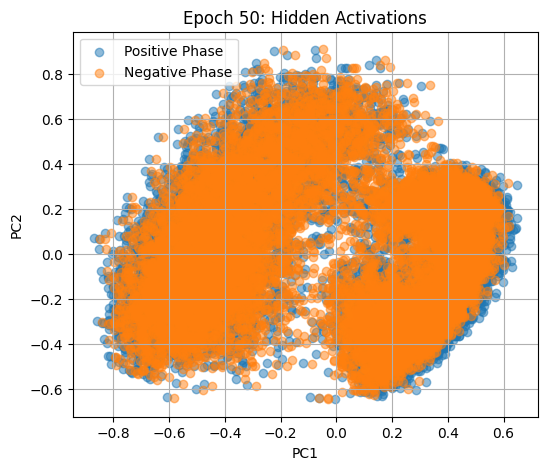

Test Accuracy: 0.8129
Epoch 60 | Hidden Phase Δ: 0.0503


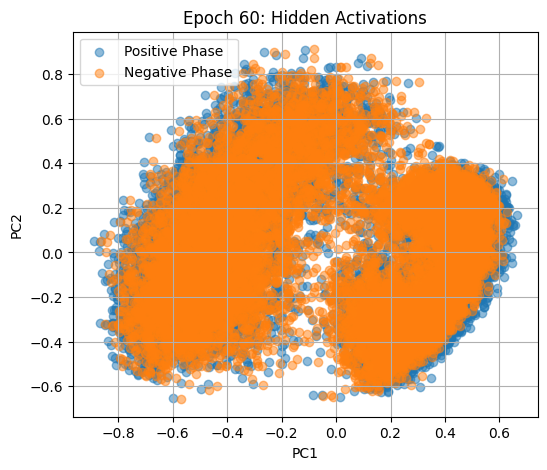

Test Accuracy: 0.8667
Epoch 70 | Hidden Phase Δ: 0.0543


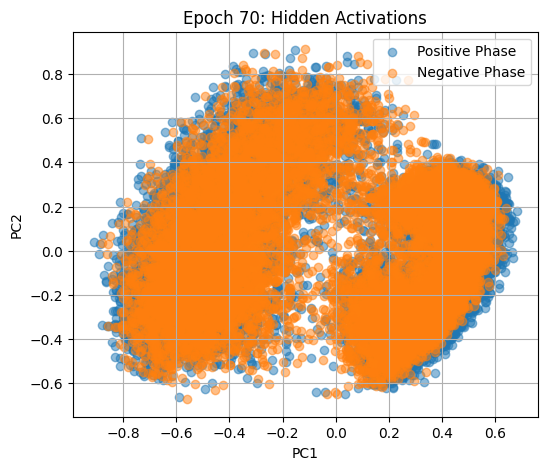

Test Accuracy: 0.9009
Epoch 80 | Hidden Phase Δ: 0.0585


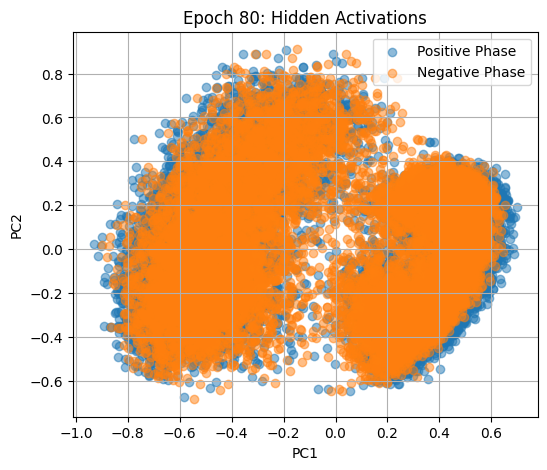

Test Accuracy: 0.9283
Epoch 90 | Hidden Phase Δ: 0.0629


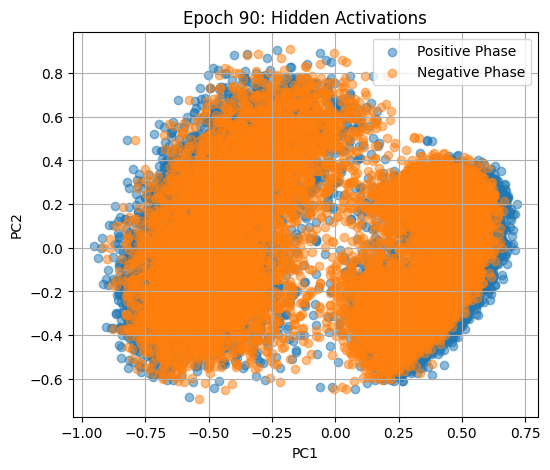

Test Accuracy: 0.9489


In [6]:

model = GeneRecNet(input_dim=784, hidden_dim=32, output_dim=2, alpha=0.3)

for epoch in range(100):
    x, pos_h, pos_y = model.forward_positive(X_train, y_train)
    _, neg_h, neg_y = model.forward_negative(X_train)
    update_weights(model, pos_h, pos_y, neg_h, neg_y, x, lr=0.05)

    if epoch % 10 == 0:
        hidden_diff = torch.norm(pos_h - neg_h, dim=0).mean().item()
        print(f"Epoch {epoch} | Hidden Phase Δ: {hidden_diff:.4f}")
        visualize_hidden(pos_h, neg_h, title=f'Epoch {epoch}: Hidden Activations')

        with torch.no_grad():
            _, _, pred = model.forward_negative(X_test)
            pred_class = torch.argmax(pred.T, dim=1)
            true_class = torch.argmax(y_test, dim=1)
            acc = (pred_class == true_class).float().mean().item()
            print(f"Test Accuracy: {acc:.4f}")
